# **Assignment 2: Homework and Lab**

- **Assigned:** Friday, February 18
- **Due:** Friday, March 4 at 5pm

Remember that you need to submit two files to CANVAS: 
* This notebook, containing all the code you implemented
* A pdf with your answers to the questions

# Homework

In [4]:
#%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import gridspec
from scipy.linalg import expm
from scipy.linalg import solve_discrete_lyapunov
from scipy.linalg import sqrtm

np.set_printoptions(precision=3)
import math
plt.rcParams["font.serif"] = "cmr14"
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 150

## Problem 1 <a name="p1"></a>

In the calculus of variations problem, where the goal is to minimize

$$
J = \int_{t_0}^{t_f} g(x,\dot{x},t)dt
$$

we showed that the first-order necessary condition is the Euler equation

$$
\frac{\partial g}{\partial x} - \frac{d}{dt} \frac{\partial g}{\partial \dot{x}} = 0,
$$

subject to various (assumed to be well defined) initial and terminal conditions, depending on the problem statement. Now consider the following:

1. If we can write $g\to g(\dot{x})$ (i.e., the function $g$ is not an explicit function of $x$ or time), show that there always exists a solution that is a linear function of time.

2. If we can write $g\to g(x,\dot{x})$ (i.e., the function $g$ is not an explicit function of time), show that

$$
g - \dot{x}\frac{\partial g}{\partial \dot{x}} = \mathrm{constant}
$$

$
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbf}{\mathbf{f}}
\newcommand{\njbg}{\mathbf{g}}
\newcommand{\njbh}{\mathbf{h}}
\newcommand{\njba}{\mathbf{a}}
\newcommand{\njbb}{\mathbf{b}}
\newcommand{\njbi}{\mathbf{i}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\njbd}{\mathbf{d}}
\newcommand{\njbp}{\mathbf{p}}
\newcommand{\njbq}{\mathbf{q}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
$

## Problem 2 <a name="p2"></a>

The Dubins car on page 6--9 of the notes (see code [here](https://colab.research.google.com/drive/1_BjMThZMhI8md9s71HfUNqP2I3B8EIdb?usp=sharing)) solved the problem of selecting the required heading rate to steer the vehicle driving at constant speed. Consider the new problem of controlling both the steering angle $\theta(t)$ with $u_1(t)$ and speed $V(t)$ with $u_2(t)$. The equations of motion are now:

$$ \left.
\begin{array}{l}
    \dot{x}(t)  =  V(t) \cos \theta(t) \\
    \dot{y}(t)  =  V(t) \sin \theta(t) \\
    \dot \theta(t)  =  u_1(t)  \\
    \dot V(t)  =  u_2(t) 
\end{array} \right\} \quad \dot \njbx = \njbf(\njbx,\njbu)
$$

where $\theta$ is heading angle wrt the $x$ axis, $V(t)$ is speed, and $u_1(t)$, $u_2(t)$ are the control inputs.

**The objective**: drive from point $A$ to $B$ (assumed to be feasible) in (nearly) minimum time:
$$
    \min J = \int_{0}^{t_f} (1+\alpha (u_1(t)^2 + u_2(t)^2)) dt
$$
where $\alpha \ll 1$ is a suitable weighting factor and
$t_f$ is free.

1. Form the Hamiltonian for this system and derive/state the resulting necessary conditions. What are the boundary conditions here?

2. Extend the provided Pyomo code to solve these necessary conditions and optimize the vehicle path. 

  Use $\alpha=0.1$ and assume that 
$x(0)=y(0)=0$, $\theta(0)=\theta(t_f)=0$, $V(0)=4$, $V(t_f)=0$, and $x(t_f)=y(t_f)=10$.

3. How long does it take the vehicle to turn around?
$x(0)=y(0)=0$, $x(t_f)=1,y(t_f)=0$, $\theta(0)=0$, $\theta(t_f)=\pi$, $V(0)=0$, $V(t_f)=0$. How does the optimal controller achieve this maneuver?

In [5]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

Running Python: 3.8.8


In [6]:
# parameters
alp = 0.1
V=0.4
X1 = 10 # Terminal State - X0 = 0 
Y1 = 10 # Terminal State - Y0 = 0
TH0 = 0 # Initial angle
V0=0
V1=0
TH1 = np.pi # Final angle
tf_estimate = sqrt((X1-0)**2+(Y1-0)**2)/V

In [7]:
# create a model object
m = ConcreteModel()

# define the independent variable
m.tf = Var(domain=NonNegativeReals, initialize = tf_estimate)
m.t = ContinuousSet(bounds=(0, 1))

# define the dependent variables
m.x = Var(m.t, initialize = 0)
m.y = Var(m.t, initialize = 0)
m.th = Var(m.t, initialize = TH0)
m.V =  Var(m.t, initialize = V0)
m.p1 = Var(m.t, initialize = 1)
m.p2 = Var(m.t, initialize = 1)
m.p3 = Var(m.t, initialize = 1)
m.p4 = Var(m.t, initialize = 1)

# define derivatives
m.x_dot = DerivativeVar(m.x)
m.y_dot = DerivativeVar(m.y)
m.th_dot = DerivativeVar(m.th)
m.V_dot = DerivativeVar(m.V)
m.p1_dot = DerivativeVar(m.p1)
m.p2_dot = DerivativeVar(m.p2)
m.p3_dot = DerivativeVar(m.p3)
m.p4_dot = DerivativeVar(m.p4)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.tf*(V*cos(m.th[t])))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.tf*(V*sin(m.th[t])))
m.ode_th = Constraint(m.t, rule=lambda m, t: m.th_dot[t] == m.tf*(-m.p3[t]/2/alp))
m.ode_V = Constraint(m.t, rule=lambda m, t: m.V_dot[t] == m.tf*(-m.p4[t]/2/alp))
m.ode_p1 = Constraint(m.t, rule=lambda m, t: m.p1_dot[t] == m.tf*(0))
m.ode_p2 = Constraint(m.t, rule=lambda m, t: m.p2_dot[t] == m.tf*(0))
m.ode_p3 = Constraint(m.t, rule=lambda m, t: m.p3_dot[t] == m.tf*m.V[t]*(m.p1[t]*sin(m.th[t])-m.p2[t]*cos(m.th[t])))
m.ode_p4 = Constraint(m.t, rule=lambda m, t: m.p4_dot[t] == m.tf*m.V[t]*(m.p1[t]*cos(m.th[t])+m.p2[t]*sin(m.th[t])))

# initial conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==0)
m.pc.add(m.y[0]==0)
m.pc.add(m.th[0]==TH0)
m.pc.add(m.V[0]==V0)

# final conditions
m.pc.add(m.x[1]==X1)
m.pc.add(m.y[1]==Y1)
m.pc.add(m.th[1]==TH1)
m.pc.add(m.V[1]==V1)
m.pc.add(1+alp*((-m.p3[1]/2/alp)**2+(m.p4[1]/2/alp)**2)+m.p1[1]*m.V[1]*cos(m.th[1])+m.p2[1]*m.V[1]*sin(m.th[1]) + m.p3[1]*(-m.p3[1]/2/alp) + m.p4[1]*(-m.p4[1]/2/alp) == 0)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, nfe=200)
#discretizer = TransformationFactory('dae.collocation')
#discretizer.apply_to(m,wrt=m.t,nfe=500,ncp=3,scheme='LAGRANGE-RADAU')
solver = SolverFactory('ipopt')
#solver.options['max_iter']= 10000 #number of iterations you wish
solver.solve(m).write()
!cp test1.txt Dubins1.txt

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.4\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3217
  Number of variables: 3217
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.13.4\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  T

mission length = 72.422 seconds


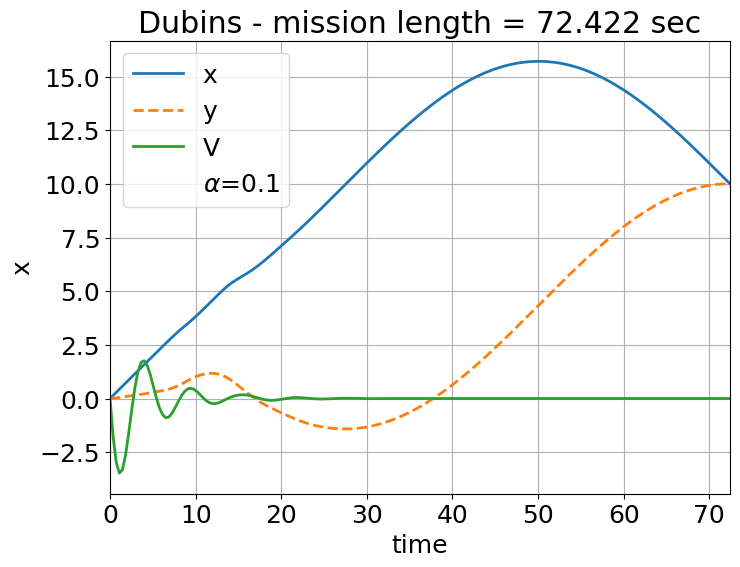

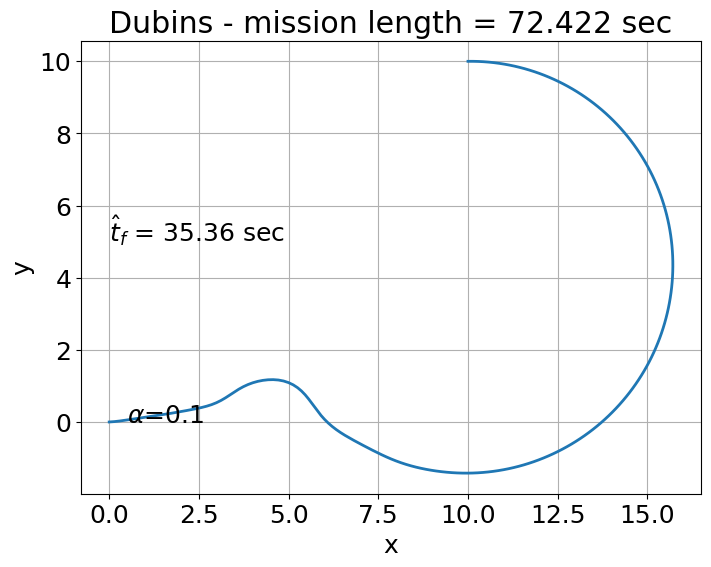

In [11]:
print('mission length = ' + str(round(m.tf(),3)) + ' seconds')

# access the results
t = np.array([t*m.tf() for t in m.t])
x = np.array([m.x[t]() for t in m.t])
y = np.array([m.y[t]() for t in m.t])
theta = np.array([m.th[t]() for t in m.t])
V = np.array([m.V[t]() for t in m.t])

p1 = np.array([m.p1[t]() for t in m.t])
p2 = np.array([m.p2[t]() for t in m.t])
p3 = np.array([m.p3[t]() for t in m.t])
p4 = np.array([m.p4[t]() for t in m.t])
u1 = -p3/2/alp
u2 = -p4/2/alp

plt.figure(1,figsize=(8,6))
plt.plot(t, x, ls='-')
plt.plot(t, y, ls='--')
#plt.plot(t, u1/5, ls=':')
#plt.plot(t, u2/5, ls='.')
plt.plot(t, V, ls='-')
plt.plot(np.NaN, np.NaN, '-', color='none')
plt.xlabel('time')
plt.ylabel('x')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.legend(['x','y','V',r'$\alpha$='+ str(round(alp,2))])
#plt.text(0.5,0,r'$\alpha$='+ str(round(alp,2)))
plt.grid(True)
plt.xlim([0,m.tf()])
plt.savefig("Dubins11.png")

plt.figure(2,figsize=(8,6))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dubins - mission length = ' + str(round(m.tf(),3)) + ' sec')
plt.grid(True)
plt.text(0,Y1/2,r'$\hat t_{f}$ = '+ str(round(tf_estimate,2))+ ' sec')
plt.text(0.5,0,r'$\alpha$='+ str(round(alp,2)))
plt.savefig("Dubins12.png")

## Problem 3 <a name="p3"></a>

We want to find the curve $x^*(t)$ that minimizes the functional
$$
J(x) = \int_0^1 \left[ \frac{1}{2}\dot{x}^2(t) + 3x(t)\dot{x}(t) + 2x^2(t) + 4x(t) \right]dt
$$
and passes through the points $x(0)=1$ and $x(1)=5$.

Please find the solution to this problem using **ALL** these three different methods:

1) Analytically
2) Solve as an optimization problem, using `pyomo`
3) Solve for the necessary conditions, using `pyomo`

Plot the results obtained, and confirm that you obtain the same results in the three cases above.

Running Python: 3.8.8
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 603
  Number of variables: 804
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.11345648765563965
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solut

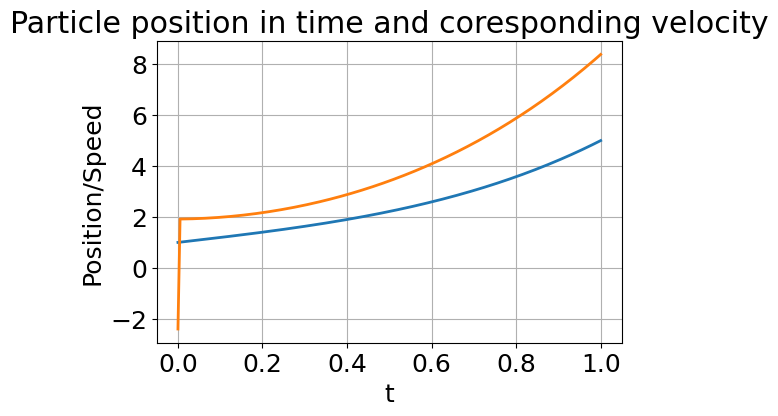

In [99]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))





# create a model object
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0, 1))
m.x = Var(m.t, initialize=1)
m.p1 = Var(m.t, initialize = 1)

m.x_dot = DerivativeVar(m.x)
m.p1_dot = DerivativeVar(m.p1)

m.ode_p1 = Constraint(m.t, rule=lambda m, t: m.p1_dot[t] == -3*m.x_dot[t]-4*m.x[t]-4)
# initial and final conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==1)
m.pc.add(m.x[1]==5)


# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, nfe=200)
#discretizer = TransformationFactory('dae.collocation')
#discretizer.apply_to(m,wrt=m.t,nfe=500,ncp=3,scheme='LAGRANGE-RADAU')
solver = SolverFactory('ipopt')
#solver.options['max_iter']= 10000 #number of iterations you wish
solver.solve(m).write()


# access the results
t = np.array([t for t in m.t])
x = np.array([m.x[t]() for t in m.t])
x_dot = np.array([m.x_dot[t]() for t in m.t])
plt.plot(t, x, ls='-', label='x')
plt.plot(t, x_dot, ls='-', label='x_dot')
plt.xlabel('t')
plt.ylabel('Position/Speed')
plt.legend
plt.title("Particle position in time and coresponding velocity")
plt.show()

## Problem 4 <a name="p4"></a>

Justification of white noise for certain problems. Consider two
problems: 
*   A) Simple first order low-pass filter with band-limited white noise as
the input: 
$y= G(s) w$, so that $S_y(j \omega) = |G(j \omega)|^2 S_w (j \omega)$, and the noise has the PSD
$$
S_1(\omega) = \left\{ \begin{array}{ll} A & | \omega | \leq \omega_c \\ 0 & | \omega | > \omega_c
\end{array} \right. \qquad
G(s) = \frac{1}{T_\omega s + 1}
$$

*   B) The same low pass system $G(s)$, but with *pure white noise* as the input
$$
S_2(\omega) = A,   \,\, \forall \omega, \qquad
G(s) = \frac{1}{T_\omega s + 1}
$$

Case A seems quite plausible, but the second has an input with
infinite variance and so is not physically realizable. 
However, the white noise assumption simplifies the system analysis
significantly, so it is important to see if the assumption is justified.

We test this with our two examples above:

1.   Sketch (or use Python/Matlab to graph) the noise PSD and $|G(j \omega)|$ for reasonable values of
$T_w$ and $\omega_c$ (i.e., choose $T_w$ and $\omega_c$ such that you can verify the statement in part 4) and compare the two cases.

2.   Determine $S_y(j \omega)$ for the two cases. Sketch these too.

3.   Determine $E\{ y^2\}$ for the two cases

3.   Use these results to justify the following statement: **If the input spectrum is flat considerably beyond the system
bandwidth, there is little error introduced by assuming that the input
spectrum is flat out to infinity.**

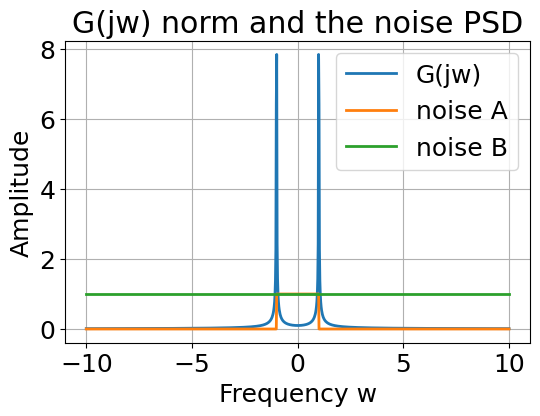

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def G_norm(w,T,w_c):
    return np.sqrt((1+T**2*w**2)/(1-T**2*w**2)**2)

T=1
w_c=1
N=1000
A=1
w_array=np.linspace(-10*w_c,10*w_c,N)
G_array=np.zeros(N)
noise_A_array=np.zeros(N)
noise_B_array=np.zeros(N)

for i in range (N):
    G_array[i]=G_norm(w_array[i],T,w_c)
    noise_B_array[i]=A
    if w_array[i]<w_c and w_array[i]>-w_c:
        noise_A_array[i]=A
    

plt.title("G(jw) norm and the noise PSD")
plt.xlabel("Frequency w")
plt.ylabel("Amplitude")
plt.plot(w_array,G_array*0.1, '-',label='G(jw)')
plt.plot(w_array,noise_A_array, '-',label='noise A')
plt.plot(w_array,noise_B_array, '-',label='noise B')
plt.legend()
plt.show()

## Problem 5

Find the shaping filter that will shape unit intensity white noise into noise with the spectral density function 

$$\Phi(j\omega) = \frac{\omega^2+4}{\omega^4+6\omega^2+25}$$

## Problem 6
Use calculus of variations techniques to find the curve that
optimizes the functional:
$$
J=\int_0^T (t\dot x + \dot x^2) \, dt
$$
subject to $x(0)=1$ and $x(T)=10$, but $T$ is free.

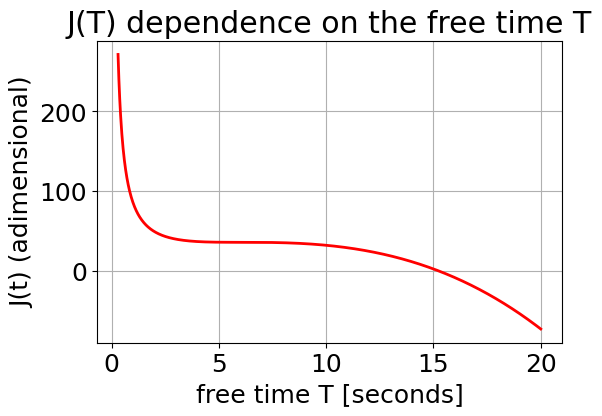

In [12]:
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
import numpy as np

def integrand(t,T):
    return t*(9.0/T+T/4.0-0.5*t)+(9.0/T+T/4.0-0.5*t)**2

N=1000
MAX_T=20
T_array=np.linspace(0.3,MAX_T,N)
J_array=np.zeros(N)

for i in range (N):
    J_array[i] = integrate.quad(integrand, 0, T_array[i], args=(T_array[i]))[0]

plt.title("J(T) dependence on the free time T")
plt.xlabel("free time T [seconds]")
plt.ylabel("J(t) (adimensional)")
plt.plot(T_array,J_array, 'r')
plt.show()


## Problem 7

For the discrete linear state space system

$$x_{k+1}=\frac{1}{2}x_k+w_k$$
$$z_{k+1}=3x_{k+1}+v_{k+1}$$

where $w_k$ and $v_k$ are WSS (Wide Sense Stationary), zero mean, uncorrelated white noise processes with $W_k=20$ and $R_k=5$, $E[x_0]=4$ and $E[(x_0-E[x_0])^2]=Q_0=10$:

1) Analytically propagate the uncertain system dynamics to find $E[x_{2}]$ and $Q_{2}$. 

2) Analytically compute the steady state values of $E[z]$ and $E[(z-E[z])^2]$.


# Lab

## Theoretical explanation: Accelerometer Calibration

An accelerometer measures [specific force](https://en.wikipedia.org/wiki/Specific_force) (i.e., mass-normalized non-gravitational force), or, acceleration relative to free-fall. That is, an accelerometer sitting on a table (with +z pointing up) will report a *positive* acceleration because the normal force of the table is preventing the accelerometer's free-fall. An accelerometer in free-fall will report 0 acceleration.

### Measurement Model

Measurements coming from an accelerometer can be modeled as

$$
\mathbf{y}_\mathbf{a} = \mathbf{f} + \mathbf{b} + \boldsymbol{\eta},
$$

where $\mathbf{f}=R^\text{b}_\text{w}(\mathbf{a} - \mathbf{g})$ is the specific force expressed in the body frame, $\mathbf{a}$ is the linear acceleration experienced by the accelerometer and $\mathbf{g}$ denotes the gravity vector, both expressed in the world coordinate frame. The $3\times 3$ matrix $R^\text{b}_\text{w}\in\text{SO}(3)$ encodes the *attitude*, or orientation, of the accelerometer w.r.t the world frame. Noise in accelerometer readings is captured with $\boldsymbol{\eta}\sim\mathcal{N}(0,\Sigma_\mathbf{a})$ and $\mathbf{b}$, which is a slowly time-varying bias. Depending on the duration of the experiment, this bias can either be treated as a constant or as a random walk.

This probabilistic measurement model is particularly useful in dynamic estimation tasks. However, this model makes the assumption that accelerometer has been calibrated for *misalignment errors* and *scale errors*. During the fabrication process, the accelerometer MEMS circutry must be placed on a die and into the [IC packaging](https://www.silicondesigns.com/tech). If the positioning is not perfect, a cross-axis sensitivity will arise where, e.g., acceleration signals solely in the x-axis will be coupled with the z-axis. Additionally, there may be a multiplicative scale factor error associated with the output of the accelerometer. These errors are captured by the matrix $M$ in the modified measurement model

$$
\mathbf{y}_\mathbf{a} = M\mathbf{f} + \mathbf{b} + \boldsymbol{\eta},
$$

where

$$
M =
\begin{bmatrix}
s_x & \gamma_{xy} & \gamma_{xz} \\
\gamma_{xy} & s_y & \gamma_{yz} \\
\gamma_{zx} & \gamma_{zy} & s_z
\end{bmatrix},
$$

and $s_i$ captures scale factor and $\gamma_{ij}$ captures cross-axis sensitivity. Note that if there is cross-axis sensitivity or scale error, $M=I$.

### Calibration

Assume that the bias term $\mathbf{b}$ is constant, which is a valid assumption for short (on the order of a few minutes) experiments. Then, to recover the uncorrupted underlying accelerometer signal $\mathbf{f}$ from measurements we would simply compute

$$
\mathbf{f} = M^{-1}(\mathbf{y}_\mathbf{a} - \mathbf{b}).
$$

Our task is to find $M$ and $\mathbf{b}$ through a calibration process. We will use the six-position calibration method [1] commonly employed by autopilots. This not only recovers the die-to-package misalignment, but any small IMU-to-vehicle-body misalignment as well. A screenshot of the accelerometer calibration process of the [Pixhawk autopilot](https://docs.px4.io/master/en/flight_controller/pixhawk4.html) is shown below (see [video](https://youtu.be/91VGmdSlbo4?t=114)).

<img src="https://docs.px4.io/v1.9.0/assets/qgc/setup/sensor/accelerometer_positions_px4.jpg" width="30%" />

#### Six Position Method

This method exploits a signal that can be measured completely in one axis at a time: gravity. By placing the IMU (or whatever it is attached to) in known orientations, we can compare measurements with the expected gravity vector. By minimizing the error between observed and expected according to the measurement model, we can use least squares to estimate the misalignment $M$ and assumed-constant bias $\mathbf{b}$.

The six orientations correspond to an expected gravity vector $\hat{\mathbf{f}}_1,\dots,\hat{\mathbf{f}}_6$. For example, if orientation 1 is the IMU aligned with the world frame (z-up), then
$$
\hat{\mathbf{f}}_1 =
\begin{bmatrix}
0\\0\\g
\end{bmatrix}.
$$

where $g \approx 9.80665 \frac{m}{s^2}$. In this lab, we provide you with a `.pkl` file that contains the accelerometer data obtained using the method above with the IMU of a NAZE32, which is a popular flight controller for drones: 

<img src="./assignment2-lab-naze32.png" alt="drawing" width="400"/>

This controller, or any of its variants, is extensively used in [First-Person View drone races](https://www.youtube.com/watch?v=QSZmSNL_0r8&t=13s). 

## Problems

1. Using the measurement model above (ignoring the white noise $\boldsymbol{\eta}$), formulate a linear system suitable for least squares estimation in the form of $\mathbf{z} = A\mathbf{x}$, where $\mathbf{z}\in\mathbb{R}^{3n}$ is a stacked vector of *expected* accelerometer measurements, $A\in\mathbb{R}^{3n\times12}$ is a matrix that depends on the corresponding *observed* accelerometer measurements, and $\mathbf{x}\in\mathbb{R}^{12}$ is a vector of unknowns. Hint: let $\bar{M}=M^{-1}$ and $\bar{\mathbf{b}}=M^{-1}\mathbf{b}$ and use the [vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) property $\mathrm{vec}(CD)=(D^\top\otimes I)\mathrm{vec}(C)$ to find $A$ and $\mathbf{x}$ (vectorized $\bar{M}$ stacked with $\bar{\mathbf{b}}$).


2. Write a calibration routine using the provided Python skeleton code, and obtain $\bar{M}$ and $\bar{\boldsymbol{b}}$.  Obtain also the following plots (12 plots in total):
    * 6 plots (one for each orientation) showing the observed accelerometer measurements (before calibration) and the expected accelerometer measurement 
    * 6 plots (one for each orientation) showing the corrected accelerometer measurements (after calibration, using $\bar{M}$ and $\bar{\boldsymbol{b}}$) and the expected accelerometer measurement 

x_up
[[ 9.979  9.955  9.995 ... 10.017  9.988  9.964]
 [ 0.257  0.307  0.3   ...  0.312  0.3    0.333]
 [ 0.214  0.262  0.235 ...  0.305  0.252  0.319]]
(3, 2340)
y_up
[[ 1.479e-01  1.456e-01  1.240e-01 ...  1.671e-01  1.288e-01  1.192e-01]
 [ 9.766e+00  9.740e+00  9.656e+00 ...  9.769e+00  9.680e+00  9.709e+00]
 [ 1.273e-02 -8.820e-03  6.779e-02 ...  1.324e-01  8.695e-02  1.779e-01]]
(3, 3550)
z_up
[[ 0.107  0.1    0.1   ...  0.067  0.031  0.038]
 [-0.215 -0.186 -0.208 ... -0.241 -0.253 -0.174]
 [ 9.834  9.882  9.87  ...  9.973  9.884  9.906]]
(3, 2764)
x_down
[[-9.690e+00 -9.635e+00 -9.683e+00 ... -9.551e+00 -9.726e+00 -9.707e+00]
 [-2.103e-01 -1.935e-01 -1.840e-01 ... -1.552e-01 -1.911e-01 -1.888e-01]
 [ 6.061e-02  3.906e-02 -4.473e-02 ...  7.019e-02 -4.031e-03  1.752e-02]]
(3, 2778)
y_down
[[-0.379 -0.379 -0.396 ... -0.364 -0.422 -0.352]
 [-9.854 -9.857 -9.847 ... -9.948 -9.948 -9.938]
 [ 0.372  0.257  0.396 ...  0.463  0.415  0.403]]
(3, 3712)
z_down
[[  0.22    0.215   0.172 ... 

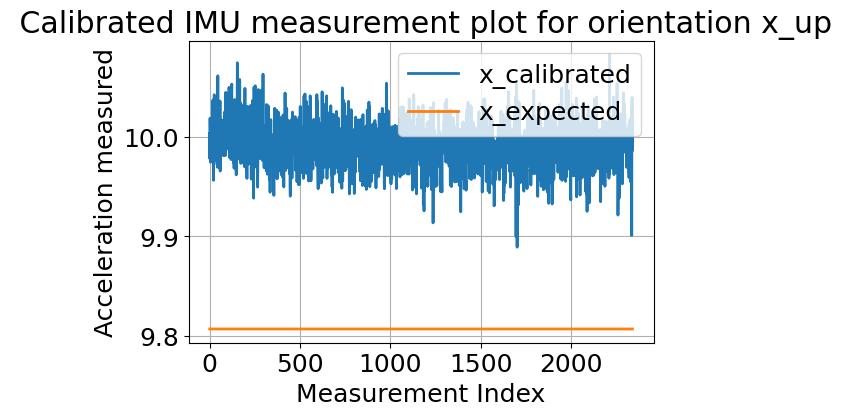

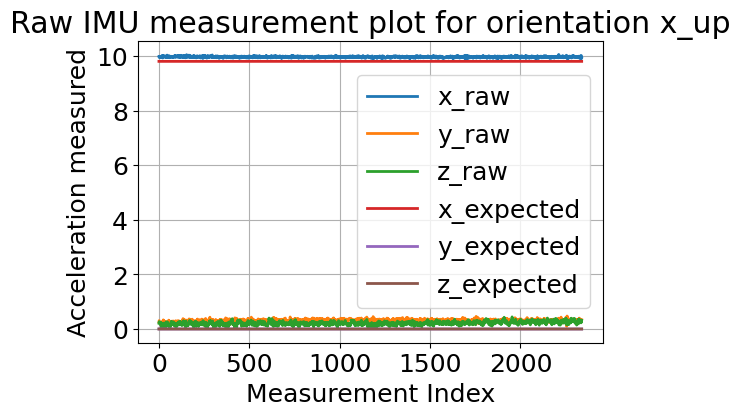

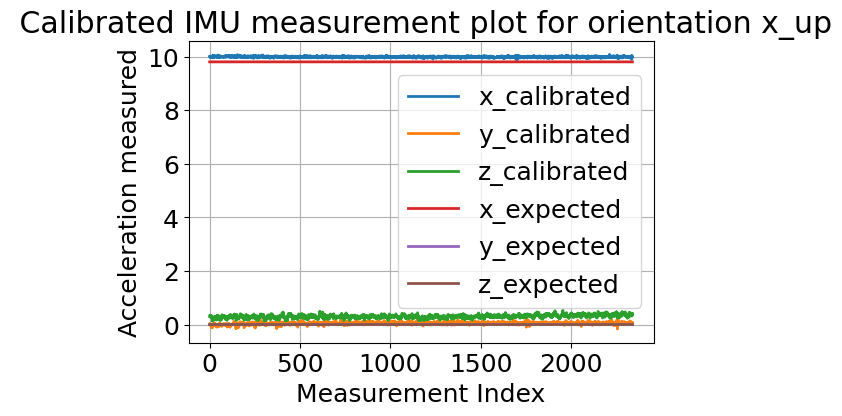

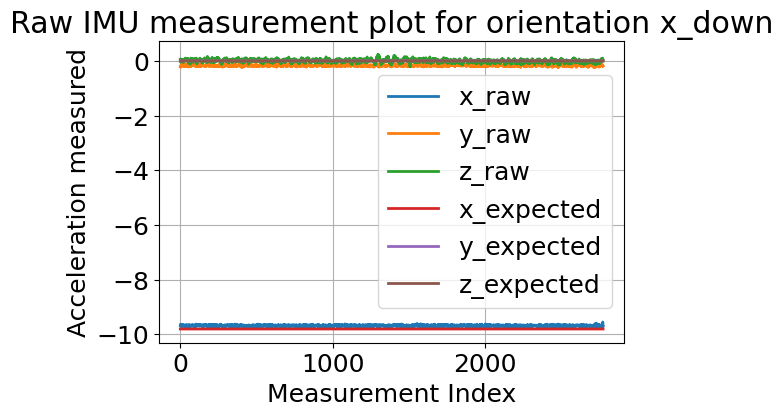

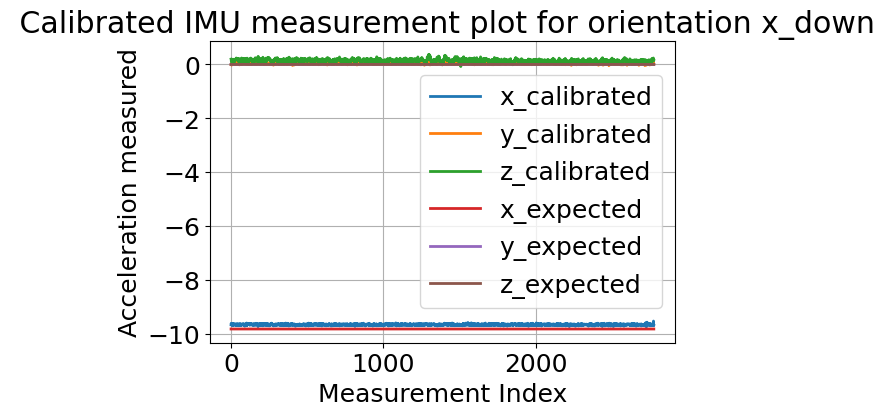

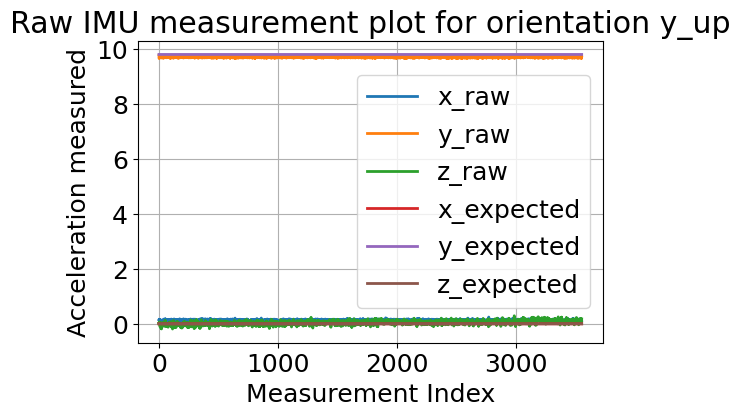

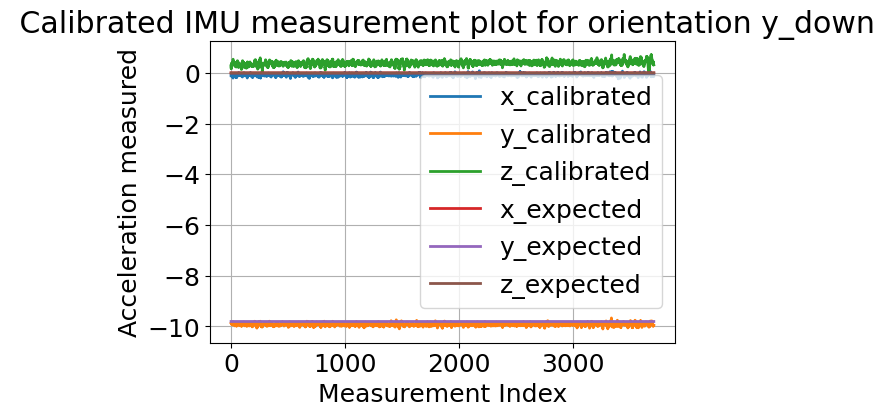

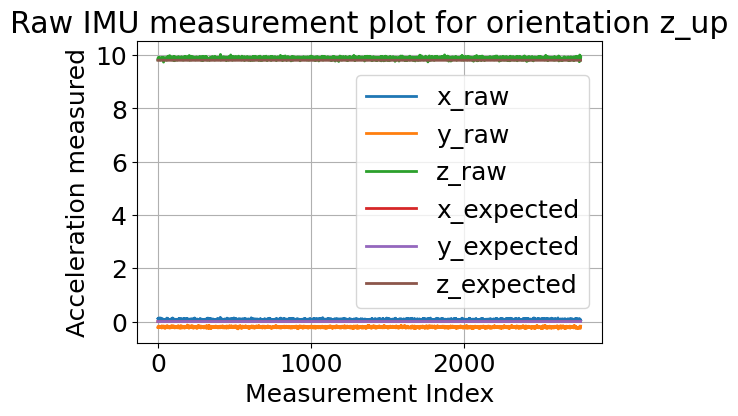

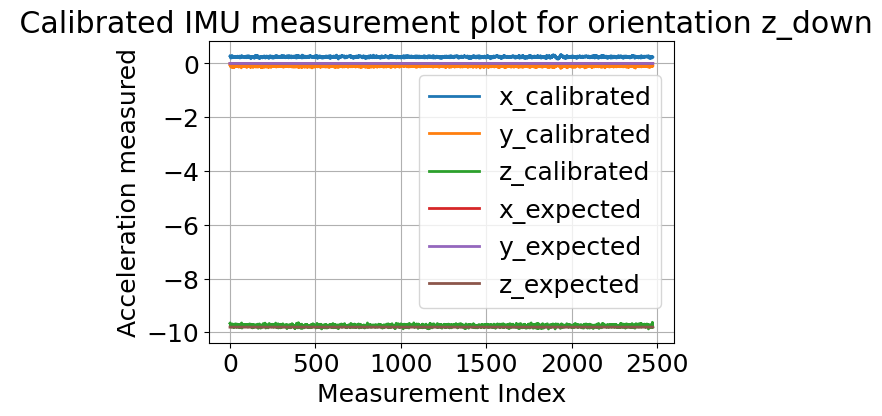

In [59]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

#gravity constant
g = 9.80665 

# list of the six orientations
orientations = ["z_up", "z_down", "x_up", "x_down", "y_up", "y_down"]
def orientation(key):
    if key=="x_up":
        return np.array([[g,0,0]]).T
    elif key=="y_up":
        return np.array([[0,g,0]]).T
    elif key=="z_up":
        return np.array([[0,0,g]]).T
    elif key=="x_down":
        return np.array([[-g,0,0]]).T
    elif key=="y_down":
        return np.array([[0,-g,0]]).T
    else:
        return np.array([[0,0,-g]]).T


y_list=[]
f_list=[]
y_calibrated={"x_up":0, "y_up":0, "z_up":0,"x_down":0, "y_down":0, "z_down":0}
f_dict={"x_up":0, "y_up":0, "z_up":0,"x_down":0, "y_down":0, "z_down":0}
#read the pkl file
with open('lab_imu_data.pkl', 'rb') as f:
    all_data = pickle.load(f)
    for key in all_data:
        print(key)
        all_data[key]=all_data[key].T
        print(all_data[key])
        print(all_data[key].shape)
        y_list.append(all_data[key])
        f_dict[key]=np.repeat(orientation(key),all_data[key].shape[1],axis=1)
        f_list.append(f_dict[key])
        
        
Y=np.hstack(y_list) 
F=np.hstack(f_list)
print('The agregated measurements matrix Y is:')
print(Y)
print(Y.shape)
print("The orientations extended matrix F is")
print(F)
print(F.shape)

#solve MF=Y using the known least squares solution, based on the Moore-Penrose pseudoinverse
Mt=np.matmul(np.linalg.pinv(F.T),Y.T)
#Mt is not yet a simmetric matrix
M=Mt.T
M=0.5*(M+M.T) #symmetrization of M
print("The symmetry corrected M matrix acounting for sensor misalignment is")
print(M)
b=np.mean(np.matmul(M,F)-Y,axis=1).T
print("Bias vector b is:")
print(b)
b=np.expand_dims(b,axis=1)
for key in all_data:
    y=all_data[key]
    y_calibrated[key]=np.matmul(np.linalg.inv(M),y-np.repeat(b,all_data[key].shape[1],axis=1))

key='x_up'

plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(y_calibrated[key][0:1,:]),'-',label='x_calibrated')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][0:1,:]),'-',label='x_expected')
plt.legend()
plt.xlabel('Measurement Index')
plt.ylabel('Acceleration measured')
plt.title(' Calibrated IMU measurement plot for orientation '+key)
plt.show()
       
for key in orientations:
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(all_data[key][0:1,:]),'-',label='x_raw')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(all_data[key][1:2,:]),'-',label='y_raw')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(all_data[key][2:3,:]),'-',label='z_raw')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][0:1,:]),'-',label='x_expected')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][1:2,:]),'-',label='y_expected')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][2:3,:]),'-',label='z_expected')
plt.legend()
plt.xlabel('Measurement Index')
plt.ylabel('Acceleration measured')
plt.title('Raw IMU measurement plot for orientation '+key)
plt.show()



plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(y_calibrated[key][0:1,:]),'-',label='x_calibrated')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(y_calibrated[key][1:2,:]),'-',label='y_calibrated')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(y_calibrated[key][2:3,:]),'-',label='z_calibrated')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][0:1,:]),'-',label='x_expected')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][1:2,:]),'-',label='y_expected')
plt.plot(np.arange(all_data[key].shape[1]),np.squeeze(f_dict[key][2:3,:]),'-',label='z_expected')

plt.legend()
plt.xlabel('Measurement Index')
plt.ylabel('Acceleration measured')
plt.title(' Calibrated IMU measurement plot for orientation '+key)
plt.show()




---
### References


[1] STMicroelectronics, "[AN4508: Parameters and calibration of a low-g 3-axis accelerometer](https://www.st.com/content/ccc/resource/technical/document/application_note/a0/f0/a0/62/3b/69/47/66/DM00119044.pdf/files/DM00119044.pdf/jcr:content/translations/en.DM00119044.pdf)", 2014.